In [88]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")
#sys.path.insert(0, r'/home/pirwin/Git/HelperPI')
import itertools
import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.formula.api as sts
import numpy as np
import math
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, classification_report, log_loss
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from scipy import interp
from sklearn.metrics import r2_score

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (11,8)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    
def decide(prob):
    if prob >= .5:
        return 1
    else:
        return 0

In [20]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [21]:
#sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\TAB_MODELING.sql")

In [22]:
#base, dtypesdf = helper.readData(sql)
base = pd.read_csv(r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\tab_model.csv', parse_dates=['DATE_VALUE'])
#base = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/tab_model.csv',parse_dates=['DATE_VALUE'])
base['DAYS_BTW_PURCH'] = base['DAYS_AS_CUSTOMER']/base['TOTAL_TRANSACTIONS']
dtypes = helper.getDtypes(base)
base.describe()

INFO:root:Getting data types...


                  Count     Column Type
0            DATE_VALUE  datetime64[ns]
1                RECORD          object
2            MEDHINC_CY         float64
3             MEDAGE_CY         float64
4            CLOSEST_BP         float64
5           CLOSEST_CAB         float64
6     MALES_IN_HOUSHOLD           int64
7   FEMALES_IN_HOUSHOLD           int64
8      REWARDS_CUSTOMER           int64
9      DAYS_AS_CUSTOMER           int64
10   TOTAL_TRANSACTIONS           int64
11     REW_TRANSACTIONS           int64
12          TOTAL_SPEND         float64
13  DAYS_SINCE_PURCHASE           int64
14       TARGET_VALUE15         float64
15  TARGET_PURCH_NEXT15           int64
16       DAYS_BTW_PURCH         float64


,MEDHINC_CY,MEDAGE_CY,CLOSEST_BP,CLOSEST_CAB,MALES_IN_HOUSHOLD,FEMALES_IN_HOUSHOLD,REWARDS_CUSTOMER,DAYS_AS_CUSTOMER,TOTAL_TRANSACTIONS,REW_TRANSACTIONS,TOTAL_SPEND,DAYS_SINCE_PURCHASE,TARGET_VALUE15,TARGET_PURCH_NEXT15,DAYS_BTW_PURCH
count,96125.000000,96125.000000,100000.000000,97531.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,58145.622294,39.521997,34.072387,109.043598,0.650080,0.333390,0.364150,2180.911420,7.957670,4.694900,701.366517,1194.241400,2.095040,0.017230,888.603640
std,22932.004376,5.807854,50.156694,159.303299,0.574073,0.493258,0.481193,1188.272088,23.068794,21.082714,1822.057170,1020.234216,28.618243,0.130128,862.637774
min,0.000000,0.000000,0.000000,0.350000,0.000000,0.000000,0.000000,57.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.686525
25%,41370.000000,36.000000,10.740000,26.360000,0.000000,0.000000,0.000000,1060.000000,1.000000,0.000000,62.210000,313.000000,0.000000,0.000000,254.650000
50%,53510.000000,39.000000,22.100000,60.050000,1.000000,0.000000,0.000000,2294.000000,2.000000,0.000000,176.900000,864.000000,0.000000,0.000000,588.500000
75%,69153.000000,43.000000,46.980000,125.425000,1.000000,1.000000,1.000000,3285.000000,6.000000,2.000000,558.715000,1916.000000,0.000000,0.000000,1225.666667
max,200001.000000,76.000000,2462.460000,5034.100000,5.000000,4.000000,1.000000,3929.000000,2115.000000,2048.000000,94600.130000,3929.000000,3689.950000,1.000000,3929.000000


### Imputing missing then Splitting the data for train and test using helper application

In [23]:
collist = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_TRANSACTIONS','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE',
          'DAYS_BTW_PURCH']
X = base[collist]
y = base['TARGET_PURCH_NEXT15']

base.TARGET_PURCH_NEXT15.value_counts()


0    98277
1     1723
Name: TARGET_PURCH_NEXT15, dtype: int64

### Determination of missing values

In [24]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / X.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.01]

,column_name,missing_count,missing_ratio
0,MEDHINC_CY,3875,0.03875
1,MEDAGE_CY,3875,0.03875


MEDHINC_CY Coef: 0.01  pval:  0.0083
MEDAGE_CY Coef: 0.00  pval:  0.1199
CLOSEST_BP Coef: -0.02  pval:  0.0000
MALES_IN_HOUSHOLD Coef: 0.06  pval:  0.0000
FEMALES_IN_HOUSHOLD Coef: 0.01  pval:  0.0167
REWARDS_CUSTOMER Coef: 0.13  pval:  0.0000
DAYS_AS_CUSTOMER Coef: 0.04  pval:  0.0000
TOTAL_TRANSACTIONS Coef: 0.22  pval:  0.0000
REW_TRANSACTIONS Coef: 0.21  pval:  0.0000
TOTAL_SPEND Coef: 0.21  pval:  0.0000
DAYS_SINCE_PURCHASE Coef: -0.11  pval:  0.0000
DAYS_BTW_PURCH Coef: -0.11  pval:  0.0000


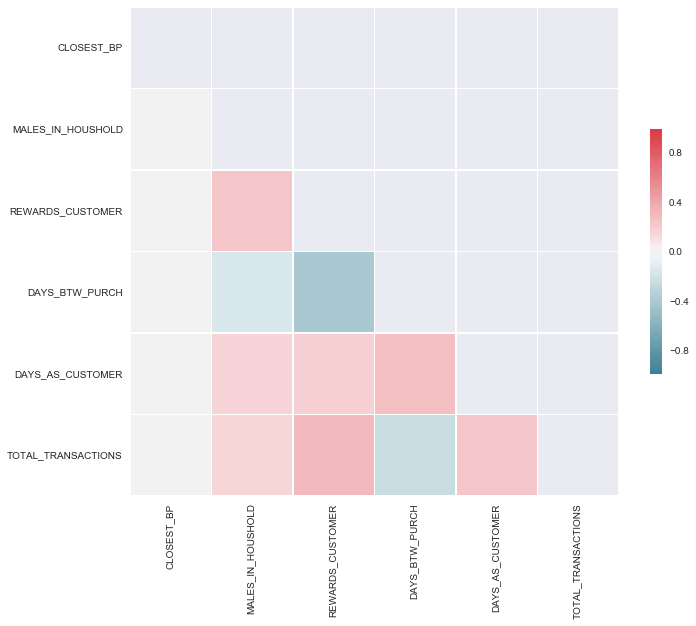

In [25]:

imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X)
imputed_data = pd.DataFrame(imr.transform(X.values), columns = collist)

for var in collist:
    coef, pval = stats.pointbiserialr(imputed_data[var].as_matrix(), y.as_matrix())
    
    print(var + ' Coef: %.2f  pval:  %.4f' % (coef, pval))


collist2 = ['CLOSEST_BP','MALES_IN_HOUSHOLD','REWARDS_CUSTOMER', 'DAYS_BTW_PURCH',
          'DAYS_AS_CUSTOMER','TOTAL_TRANSACTIONS']

imputed_data2 = imputed_data[collist2]
    
corr = imputed_data2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.99, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


    



In [26]:
train_X, test_X, train_y, test_y = helper.splitData2(imputed_data2, y, 0.1)

train_X, val_X, train_y, val_y = helper.splitData2(train_X, train_y, 0.2)

print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

train_X = pd.DataFrame(train_X, columns=collist2)
test_X = pd.DataFrame(test_X, columns=collist2)

(72000, 6) (72000,) (18000, 6) (18000,) (10000, 6) (10000,)


In [27]:
train_X.head()

,CLOSEST_BP,MALES_IN_HOUSHOLD,REWARDS_CUSTOMER,DAYS_BTW_PURCH,DAYS_AS_CUSTOMER,TOTAL_TRANSACTIONS
41156,3.63,0.0,0.0,1874.50,3749.0,2.0
71141,9.87,1.0,0.0,1226.00,1226.0,1.0
64922,4.68,1.0,1.0,238.75,955.0,4.0
10193,72.75,1.0,0.0,370.00,370.0,1.0
97887,80.68,0.0,0.0,1262.00,1262.0,1.0


In [156]:

stdsc = StandardScaler()
train_X_std = pd.DataFrame(stdsc.fit_transform(train_X), columns=collist2)
val_X_std = pd.DataFrame(stdsc.fit_transform(val_X), columns=collist2)
test_X_std = pd.DataFrame(stdsc.fit_transform(test_X), columns=collist2)

sm = SMOTE(random_state=123, ratio=1.0)
train_X_std_res, train_y_res = sm.fit_sample(train_X_std, train_y)

#train_X_std_res = pd.DataFrame(train_X_std_res, columns = collist2)
#train_y_res = pd.DataFrame(train_y_res)
sum(test_y)


INFO:imblearn.base:Compute classes statistics ...
INFO:imblearn.base:2 classes detected: Counter({0: 70766, 1: 1234})
INFO:imblearn.base:Generated 69532 new samples ...


211

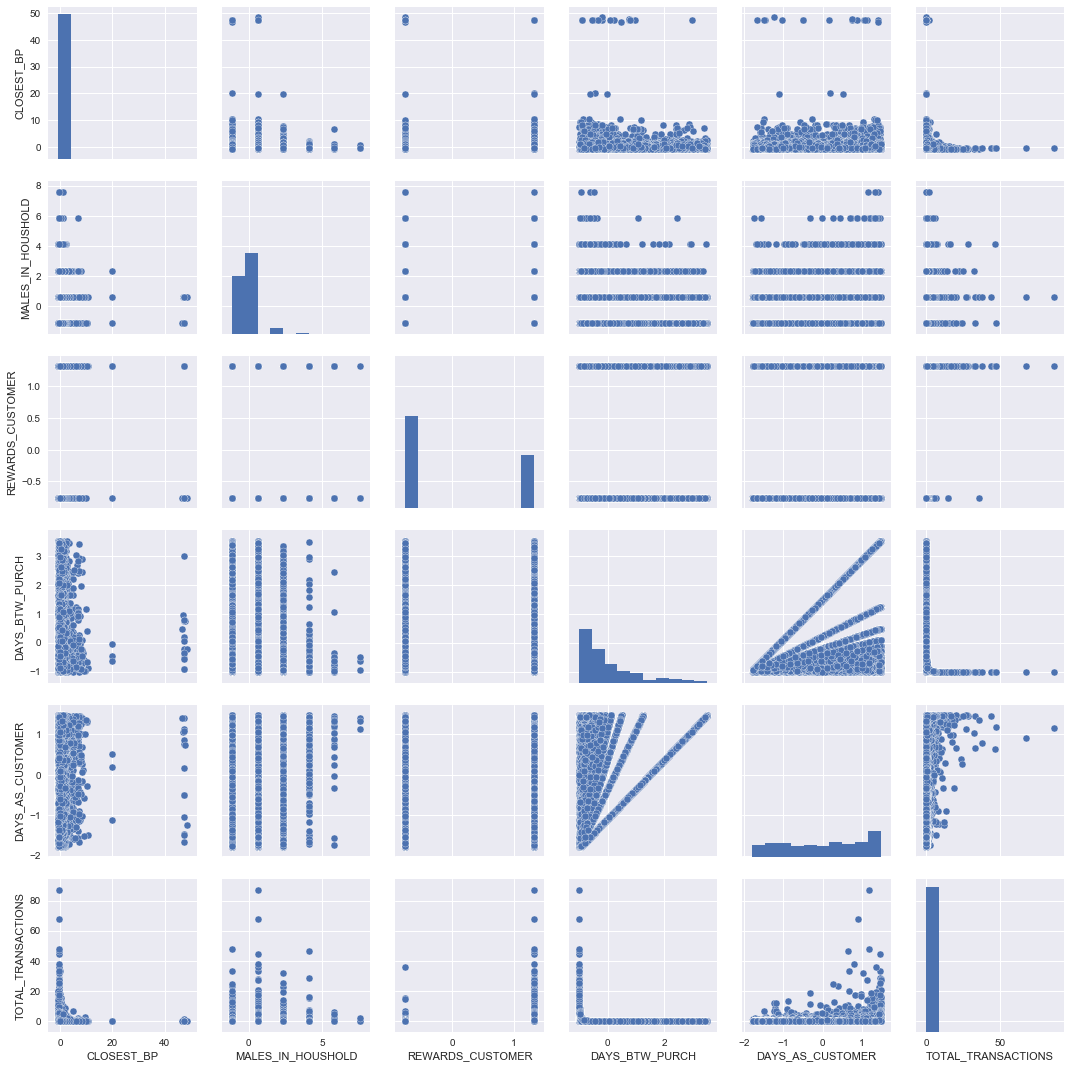

In [29]:
sns.pairplot(train_X_std, hue=None)
#sns.plt.savefig('Scattermatrix.png')
plt.show()

In [30]:
sum(test_y), len(test_y)

(211, 10000)

 1) TOTAL_TRANSACTIONS             0.360894
 2) DAYS_BTW_PURCH                 0.283422
 3) DAYS_AS_CUSTOMER               0.132925
 4) CLOSEST_BP                     0.122754
 5) REWARDS_CUSTOMER               0.069470
 6) MALES_IN_HOUSHOLD              0.030535


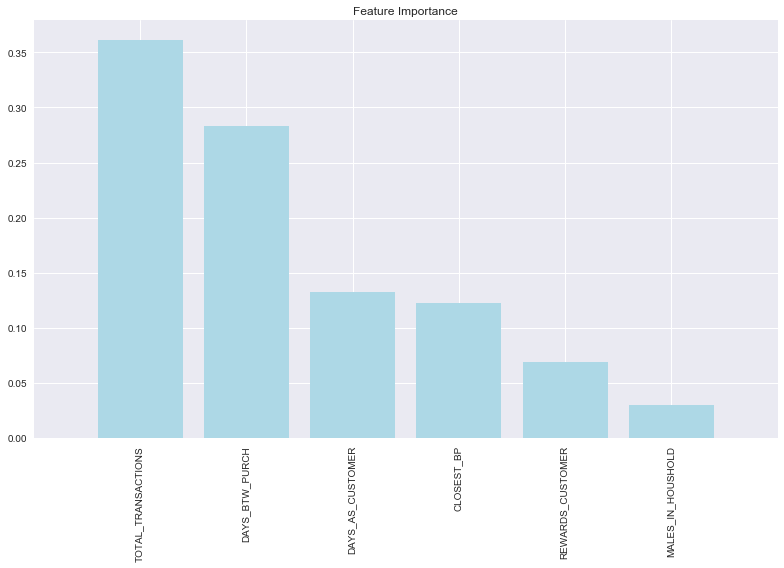

In [31]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = np.asarray(collist2)

forests = RandomForestClassifier(n_estimators=300,
                                random_state=0,
                                n_jobs=-1)
forests.fit(train_X_std_res, train_y_res)
importances = forests.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(train_X_std_res.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],
                                      importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(train_X_std_res.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(train_X_std_res.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, train_X_std_res.shape[1]])
plt.tight_layout()
plt.show()

### Parameter Tuning Version

In [32]:
def modelfit(alg, dtrain, dlabels, feature_names, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=dlabels.values, feature_names = feature_names)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain, dlabels, eval_metric='auc')

    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dlabels.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dlabels.values, dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    
    


Model Report
Accuracy : 0.983
AUC Score (Train): 0.901360


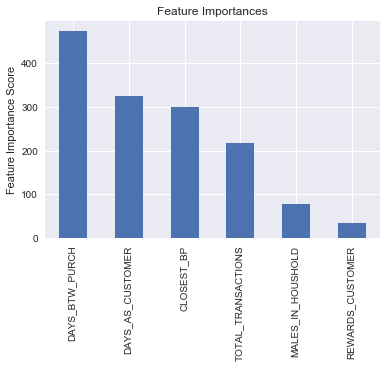

In [110]:
xgb1 = xgb.XGBClassifier(
    learning_rate = 0.07,
    n_estimators = 140,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.7,
    colsample_bytree = 0.7,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = 27)

modelfit(xgb1, train_X_std, train_y, collist2)

In [75]:
param_test1 = {
     'max_delta_step': [0,1,2,3,4,5,6]
#     'max_depth':list(range(3,12,2)),
#     'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, max_delta_step = 1),
     param_grid = param_test1, scoring='roc_auc', iid=False, cv=5)

gsearch1.fit(train_X_std.values, train_y)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06696, std: 0.00192, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.06694, std: 0.00201, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.06700, std: 0.00197, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.06782, std: 0.00195, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.06798, std: 0.00204, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.06785, std: 0.00196, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.06895, std: 0.00208, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.06908, std: 0.00196, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.06897, std: 0.00208, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.07052, std: 0.00204, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.07026, std: 0.00212, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.07014, std: 0.00217, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: -0.07214, std: 0.001

In [77]:
#max_delta_step = 1
#max_depth = 3
#min_child_weight = 3


param_test2 = {
    'max_depth': [2,3,4],
    'min_child_weight':[2,3,4]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
     min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test2, scoring='neg_log_loss', iid=False, cv=5)

gsearch2.fit(train_X_std, train_y)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06682, std: 0.00200, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: -0.06680, std: 0.00197, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -0.06679, std: 0.00196, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -0.06696, std: 0.00199, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -0.06694, std: 0.00201, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.06699, std: 0.00197, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -0.06744, std: 0.00195, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -0.06737, std: 0.00199, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.06741, std: 0.00199, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 2, 'min_child_weight': 4},
 -0.066791664481817128)

In [78]:
#max_delta_step=1
#max_depth = 2
#min_child_weight = 4


param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=4, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test3, scoring='neg_log_loss', iid=False, cv=5)

gsearch3.fit(train_X_std, train_y)

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06679, std: 0.00196, params: {'gamma': 0.0},
  mean: -0.06679, std: 0.00196, params: {'gamma': 0.1},
  mean: -0.06680, std: 0.00197, params: {'gamma': 0.2},
  mean: -0.06680, std: 0.00197, params: {'gamma': 0.3},
  mean: -0.06680, std: 0.00197, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 -0.066790050086828132)

In [79]:
#max_delta_step=1
#max_depth = 2
#min_child_weight = 4
# gamma = 0.1

param_test4 = {
    'gamma':[0.05, 0.1, 0.15]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=4, gamma=0.1, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test4, scoring='neg_log_loss', iid=False, cv=5)

gsearch4.fit(train_X_std, train_y)

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06679, std: 0.00196, params: {'gamma': 0.05},
  mean: -0.06679, std: 0.00196, params: {'gamma': 0.1},
  mean: -0.06680, std: 0.00197, params: {'gamma': 0.15}],
 {'gamma': 0.1},
 -0.066790050086828132)

In [80]:
#max-delta_step=1
#max_depth = 2
#min_child_weight = 4
#gamma = 0.1

param_test4 = {
     'subsample':[i/10.0 for i in range(5,11)],
     'colsample_bytree':[i/10.0 for i in range(5,11)],
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=4, gamma=0.1, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test4, scoring='neg_log_loss', iid=False, cv=5)

gsearch4.fit(train_X_std_res, train_y_res)

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.35962, std: 0.00547, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: -0.35891, std: 0.00604, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: -0.35799, std: 0.00611, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: -0.35813, std: 0.00567, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: -0.35771, std: 0.00605, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: -0.36666, std: 0.00443, params: {'colsample_bytree': 0.5, 'subsample': 1.0},
  mean: -0.35962, std: 0.00547, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.35891, std: 0.00604, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.35799, std: 0.00611, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.35813, std: 0.00567, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.35771, std: 0.00605, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.36666, std: 0.00443, params: {'colsample_bytree': 0.6,

In [81]:
#max_delta_step
#max_depth = 2
#min_child_weight = 4
#gamma = 0.1
#subsample = 1.0
#colsample_bytree = 1.0

param_test5 = {
     'subsample':[0.9, 0.95, 1.0],
     'colsample_bytree':[0.9, 0.95, 1.0]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=4, gamma=0.1, subsample=1.0, colsample_bytree=1.0,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test5, scoring='neg_log_loss', iid=False, cv=5)

gsearch5.fit(train_X_std, train_y)

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.06672, std: 0.00203, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: -0.06673, std: 0.00205, params: {'colsample_bytree': 0.9, 'subsample': 0.95},
  mean: -0.06669, std: 0.00203, params: {'colsample_bytree': 0.9, 'subsample': 1.0},
  mean: -0.06672, std: 0.00203, params: {'colsample_bytree': 0.95, 'subsample': 0.9},
  mean: -0.06673, std: 0.00205, params: {'colsample_bytree': 0.95, 'subsample': 0.95},
  mean: -0.06669, std: 0.00203, params: {'colsample_bytree': 0.95, 'subsample': 1.0},
  mean: -0.06674, std: 0.00197, params: {'colsample_bytree': 1.0, 'subsample': 0.9},
  mean: -0.06673, std: 0.00204, params: {'colsample_bytree': 1.0, 'subsample': 0.95},
  mean: -0.06671, std: 0.00206, params: {'colsample_bytree': 1.0, 'subsample': 1.0}],
 {'colsample_bytree': 0.9, 'subsample': 1.0},
 -0.066689591265338216)

In [82]:
#max_delta_step = 1
#max_depth = 2
#min_child_weight = 4
#gamma = 0.1
#subsample = 0.9
#colsample_bytree = 1.0

param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=4, gamma=0.1, subsample=1.0, colsample_bytree=0.9,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test6, scoring='neg_log_loss', iid=False, cv=5)

gsearch6.fit(train_X_std_res, train_y_res)

gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.34209, std: 0.00631, params: {'reg_alpha': 1e-05},
  mean: -0.34198, std: 0.00633, params: {'reg_alpha': 0.01},
  mean: -0.34189, std: 0.00630, params: {'reg_alpha': 0.1},
  mean: -0.34044, std: 0.00809, params: {'reg_alpha': 1},
  mean: -0.34724, std: 0.00589, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 -0.34043712327390568)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : 0.9851
AUC Score (Train): 0.999050


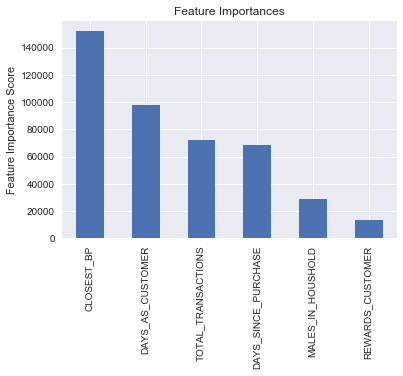

In [34]:
#max_delta_step = 1
#max_depth = 2
#min_child_weight = 4
#gamma = 0.1
#subsample = 0.9
#colsample_bytree = 1.0
#reg_alpha = 1

xgb3 = xgb.XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 1000,
    max_depth = 12,
    min_child_weight = 0,
    gamma = 0.0,
    subsample = 0.9,
    colsample_bytree = 1.0,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    reg_alpha=1e-05,
    seed = 27)

modelfit(xgb3, pd.DataFrame(train_X_std_res, columns=collist2), pd.DataFrame(train_y_res), collist2)

In [33]:
#max_delta_step = 1
#max_depth = 2
#min_child_weight = 4
#gamma = 0.1
#subsample = 0.9
#colsample_bytree = 1.0
#reg_alpha = 1

tuned_model = xgb.XGBClassifier(learning_rate = 0.01,
                        n_estimators = 1000,
                        max_depth = 2,
                        min_child_weight = 4,
                        gamma = 0.1,
                        subsample = 0.9,
                        colsample_bytree = 1.0,
                        objective = 'binary:logistic',
                        scale_pos_weight = 1,
                        reg_alpha= 1,
                        max_delta_step = 1,
                        seed = 27)
xgbmodel = tuned_model.fit(train_X_std.values, train_y.values, 
                 eval_set=[(train_X_std.values, train_y.values), (val_X_std.values, val_y), (test_X_std.values, test_y)], 
                 eval_metric='auc',
                 early_stopping_rounds=50,                 
                 verbose=True)

#fig, ax = plt.subplots(figsize=(12,18))
#xgb.plot_importance(xgbmodel, height=0.8, ax=ax)
#plt.show()


[0]	validation_0-auc:0.509541	validation_1-auc:0.503343	validation_2-auc:0.509272
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.516261	validation_1-auc:0.50677	validation_2-auc:0.513961
[2]	validation_0-auc:0.516249	validation_1-auc:0.50677	validation_2-auc:0.513958
[3]	validation_0-auc:0.516248	validation_1-auc:0.50677	validation_2-auc:0.513958
[4]	validation_0-auc:0.516248	validation_1-auc:0.50677	validation_2-auc:0.513958
[5]	validation_0-auc:0.516249	validation_1-auc:0.50677	validation_2-auc:0.513958
[6]	validation_0-auc:0.516248	validation_1-auc:0.506771	validation_2-auc:0.513958
[7]	validation_0-auc:0.516248	validation_1-auc:0.506771	validation_2-auc:0.513958
[8]	validation_0-auc:0.516248	validation_1-auc:0.506771	validation_2-auc:0.513958
[9]	validation_0-auc:0.516248	validation_1-auc:0.506771	validation_2-auc:0.513958
[10]	validation_0-auc:0.5162

[98]	validation_0-auc:0.696772	validation_1-auc:0.69385	validation_2-auc:0.674708
[99]	validation_0-auc:0.696775	validation_1-auc:0.693859	validation_2-auc:0.674712
[100]	validation_0-auc:0.696778	validation_1-auc:0.693865	validation_2-auc:0.674726
[101]	validation_0-auc:0.696783	validation_1-auc:0.693852	validation_2-auc:0.674723
[102]	validation_0-auc:0.703348	validation_1-auc:0.697737	validation_2-auc:0.684777
[103]	validation_0-auc:0.703351	validation_1-auc:0.697729	validation_2-auc:0.684778
[104]	validation_0-auc:0.703358	validation_1-auc:0.69776	validation_2-auc:0.684809
[105]	validation_0-auc:0.703352	validation_1-auc:0.697726	validation_2-auc:0.684776
[106]	validation_0-auc:0.703371	validation_1-auc:0.697722	validation_2-auc:0.684759
[107]	validation_0-auc:0.703372	validation_1-auc:0.69774	validation_2-auc:0.684764
[108]	validation_0-auc:0.703368	validation_1-auc:0.697733	validation_2-auc:0.684754
[109]	validation_0-auc:0.703371	validation_1-auc:0.697712	validation_2-auc:0.6847

[196]	validation_0-auc:0.833677	validation_1-auc:0.827937	validation_2-auc:0.824545
[197]	validation_0-auc:0.833681	validation_1-auc:0.827957	validation_2-auc:0.825091
[198]	validation_0-auc:0.833658	validation_1-auc:0.827965	validation_2-auc:0.825071
[199]	validation_0-auc:0.833714	validation_1-auc:0.828063	validation_2-auc:0.825154
[200]	validation_0-auc:0.833736	validation_1-auc:0.827908	validation_2-auc:0.825366
[201]	validation_0-auc:0.833763	validation_1-auc:0.827859	validation_2-auc:0.825401
[202]	validation_0-auc:0.833785	validation_1-auc:0.827841	validation_2-auc:0.825385
[203]	validation_0-auc:0.833789	validation_1-auc:0.827906	validation_2-auc:0.825417
[204]	validation_0-auc:0.833838	validation_1-auc:0.827872	validation_2-auc:0.825505
[205]	validation_0-auc:0.833833	validation_1-auc:0.827865	validation_2-auc:0.825497
[206]	validation_0-auc:0.833855	validation_1-auc:0.827874	validation_2-auc:0.825472
[207]	validation_0-auc:0.833849	validation_1-auc:0.827865	validation_2-auc:0

[294]	validation_0-auc:0.866167	validation_1-auc:0.863553	validation_2-auc:0.854075
[295]	validation_0-auc:0.866172	validation_1-auc:0.863635	validation_2-auc:0.854234
[296]	validation_0-auc:0.868297	validation_1-auc:0.863639	validation_2-auc:0.854225
[297]	validation_0-auc:0.868299	validation_1-auc:0.863607	validation_2-auc:0.854064
[298]	validation_0-auc:0.868305	validation_1-auc:0.863676	validation_2-auc:0.854242
[299]	validation_0-auc:0.86831	validation_1-auc:0.863676	validation_2-auc:0.854224
[300]	validation_0-auc:0.868318	validation_1-auc:0.863686	validation_2-auc:0.85423
[301]	validation_0-auc:0.868391	validation_1-auc:0.863735	validation_2-auc:0.854377
[302]	validation_0-auc:0.868476	validation_1-auc:0.863882	validation_2-auc:0.854517
[303]	validation_0-auc:0.868457	validation_1-auc:0.864117	validation_2-auc:0.854256
[304]	validation_0-auc:0.868483	validation_1-auc:0.864077	validation_2-auc:0.854295
[305]	validation_0-auc:0.868476	validation_1-auc:0.864029	validation_2-auc:0.8

[392]	validation_0-auc:0.878157	validation_1-auc:0.87159	validation_2-auc:0.859504
[393]	validation_0-auc:0.878152	validation_1-auc:0.871565	validation_2-auc:0.859483
[394]	validation_0-auc:0.878171	validation_1-auc:0.871574	validation_2-auc:0.859466
[395]	validation_0-auc:0.878206	validation_1-auc:0.871651	validation_2-auc:0.859484
[396]	validation_0-auc:0.878206	validation_1-auc:0.871656	validation_2-auc:0.859556
[397]	validation_0-auc:0.878226	validation_1-auc:0.871694	validation_2-auc:0.859598
[398]	validation_0-auc:0.878246	validation_1-auc:0.871745	validation_2-auc:0.859592
[399]	validation_0-auc:0.878256	validation_1-auc:0.871798	validation_2-auc:0.859635
[400]	validation_0-auc:0.878266	validation_1-auc:0.871743	validation_2-auc:0.859618
[401]	validation_0-auc:0.878277	validation_1-auc:0.871723	validation_2-auc:0.859677
[402]	validation_0-auc:0.878325	validation_1-auc:0.871694	validation_2-auc:0.859623
[403]	validation_0-auc:0.878343	validation_1-auc:0.871716	validation_2-auc:0.

In [37]:
print('Recall train: ' + str(recall_score(train_y, xgbmodel.predict(train_X_std.values))))
print('Recall validation: ' + str(recall_score(val_y, xgbmodel.predict(val_X_std.values))))
print('Recall test: ' + str(recall_score(test_y, xgbmodel.predict(test_X_std.values))))

Recall train: 0.0
Recall validation: 0.0
Recall test: 0.0


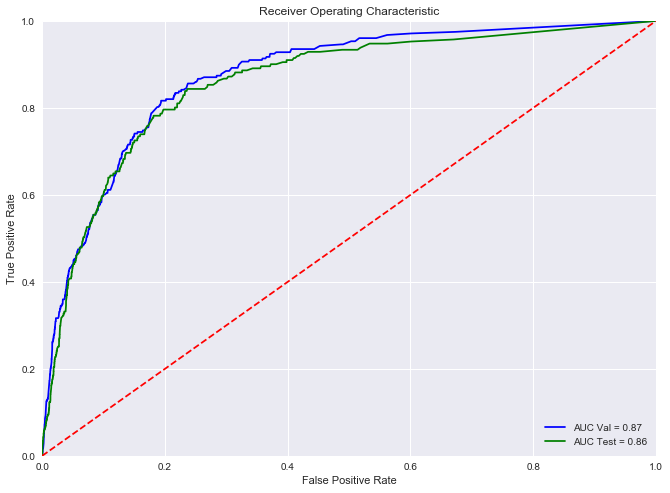

In [38]:
pred_y = xgbmodel.predict_proba(test_X_std.values)[:,1]

#accuracy = accuracy_score(test_y, pred_y)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, xgbmodel.predict_proba(val_X_std.values)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, xgbmodel.predict_proba(test_X_std.values)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###  Alternate Parameter tuning - only for fast running algorithms

In [65]:

tuned_parameters = [{
    'C': [1000, 100, 10, 1, .1, .01, .001],
    'dual': [False]
}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = val_y, clf.predict(val_X_std)
    y_true2, y_pred2 = test_y, clf.predict(test_X_std)
    print('AUC Val: ' + str(roc_auc_score(y_true, y_pred)))
    print('Recall Val: ' + str(recall_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))
    print()
    print('AUC Test: ' + str(roc_auc_score(y_true2, y_pred2)))
    print('Recall Test: ' + str(recall_score(y_true2, y_pred2)))
    print(classification_report(y_true2, y_pred2))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'dual': False}

Grid scores on development set:

0.830 (+/-0.003) for {'C': 1000, 'dual': False}
0.830 (+/-0.003) for {'C': 100, 'dual': False}
0.830 (+/-0.003) for {'C': 10, 'dual': False}
0.830 (+/-0.003) for {'C': 1, 'dual': False}
0.830 (+/-0.003) for {'C': 0.1, 'dual': False}
0.830 (+/-0.003) for {'C': 0.01, 'dual': False}
0.826 (+/-0.003) for {'C': 0.001, 'dual': False}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

AUC Val: 0.797908586572
Recall Val: 0.856115107914
             precision    recall  f1-score   support

          0       1.00      0.74      0.85     17722
          1       0.05      0.86      0.09       278

avg / total       0.98      0.74      0.84     18000


AUC Test: 0.783504213793
Recall Test: 0.824644549763
             precision    recall  f1-score   support

          0  

             precision    recall  f1-score   support

          0       0.99      0.75      0.86      9789
          1       0.06      0.80      0.12       211

avg / total       0.97      0.75      0.84     10000

Accuracy: 75.38%


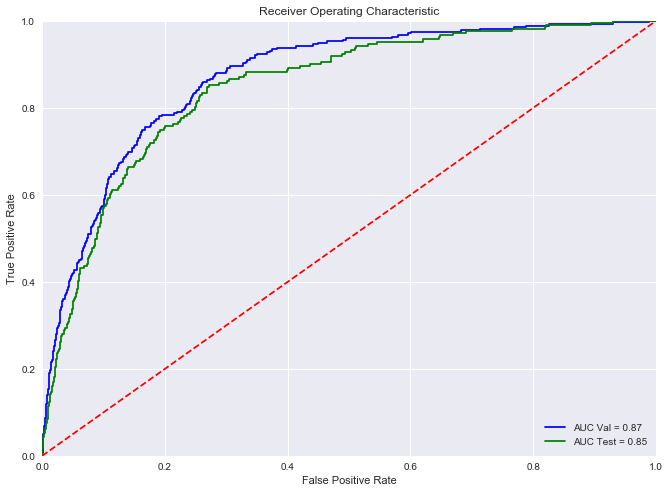

In [66]:
svm = LinearSVC(C=1000,dual=False)

clf = CalibratedClassifierCV(svm, method='sigmoid', cv=5)

svcmodel = clf.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, svcmodel.predict(test_X_std)))


# evaluate predictions
accuracy = accuracy_score(test_y, svcmodel.predict(test_X_std))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, svcmodel.predict_proba(val_X_std)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, svcmodel.predict_proba(test_X_std)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
tuned_parameters = [{
    'C': [1000, 100, 10, 1, .1, .01, .001],
    'dual':[False],
    'solver': ['liblinear','sag']
}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = val_y, clf.predict_proba(val_X_std)[:,1]
    y_true2, y_pred2 = test_y, clf.predict_proba(test_X_std)[:,1]
    print('AUC Val: ' + str(roc_auc_score(y_true, y_pred)))
    print('Recall Val: ' + str(recall_score(y_true, clf.predict(val_X_std))))
    print(classification_report(y_true, clf.predict(val_X_std)))
    print()
    print('AUC Test: ' + str(roc_auc_score(y_true2, y_pred2)))
    print('Recall Test: ' + str(recall_score(y_true2, clf.predict(test_X_std))))
    print(classification_report(y_true2, clf.predict(test_X_std)))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'dual': False, 'solver': 'liblinear'}

Grid scores on development set:

0.835 (+/-0.002) for {'C': 1000, 'dual': False, 'solver': 'liblinear'}
0.835 (+/-0.002) for {'C': 1000, 'dual': False, 'solver': 'sag'}
0.835 (+/-0.002) for {'C': 100, 'dual': False, 'solver': 'liblinear'}
0.835 (+/-0.002) for {'C': 100, 'dual': False, 'solver': 'sag'}
0.835 (+/-0.002) for {'C': 10, 'dual': False, 'solver': 'liblinear'}
0.835 (+/-0.002) for {'C': 10, 'dual': False, 'solver': 'sag'}
0.835 (+/-0.002) for {'C': 1, 'dual': False, 'solver': 'liblinear'}
0.835 (+/-0.002) for {'C': 1, 'dual': False, 'solver': 'sag'}
0.835 (+/-0.002) for {'C': 0.1, 'dual': False, 'solver': 'liblinear'}
0.835 (+/-0.002) for {'C': 0.1, 'dual': False, 'solver': 'sag'}
0.829 (+/-0.001) for {'C': 0.01, 'dual': False, 'solver': 'liblinear'}
0.829 (+/-0.001) for {'C': 0.01, 'dual': False, 'solver': 'sag'}
0.813 (+/-0.002) for {'C': 0.

             precision    recall  f1-score   support

          0       1.00      0.76      0.86      9789
          1       0.07      0.83      0.13       211

avg / total       0.98      0.76      0.85     10000

Accuracy: 76.28%


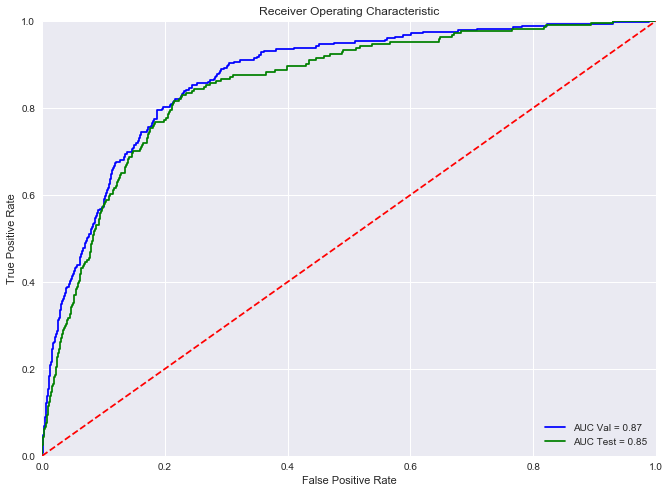

In [70]:

log = LogisticRegressionCV(Cs=100, cv=5, solver='liblinear')

logmodel = log.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, logmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y,logmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, logmodel.predict_proba(val_X_std)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, logmodel.predict_proba(test_X_std)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
tuned_parameters = [{
    'loss':['hinge','log'],
    
}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SGDClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = val_y, clf.predict_proba(val_X_std)[:,1]
    y_true2, y_pred2 = test_y, clf.predict_proba(test_X_std)[:,1]
    print('AUC Val: ' + str(roc_auc_score(y_true, y_pred)))
    print('Recall Val: ' + str(recall_score(y_true, clf.predict(val_X_std))))
    print(classification_report(y_true, clf.predict(val_X_std)))
    print()
    print('AUC Test: ' + str(roc_auc_score(y_true2, y_pred2)))
    print('Recall Test: ' + str(recall_score(y_true2, clf.predict(test_X_std))))
    print(classification_report(y_true2, clf.predict(test_X_std)))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'loss': 'log'}

Grid scores on development set:

0.847 (+/-0.045) for {'loss': 'hinge'}
0.848 (+/-0.025) for {'loss': 'log'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

AUC Val: 0.869869300362
Recall Val: 0.812949640288
             precision    recall  f1-score   support

          0       1.00      0.78      0.88     17722
          1       0.06      0.81      0.10       278

avg / total       0.98      0.78      0.86     18000


AUC Test: 0.8509517647
Recall Test: 0.815165876777
             precision    recall  f1-score   support

          0       0.99      0.79      0.88      9789
          1       0.08      0.82      0.14       211

avg / total       0.98      0.79      0.86     10000



             precision    recall  f1-score   support

          0       0.99      0.78      0.87      9789
          1       0.07      0.80      0.13       211

avg / total       0.97      0.78      0.86     10000

Accuracy: 76.28%


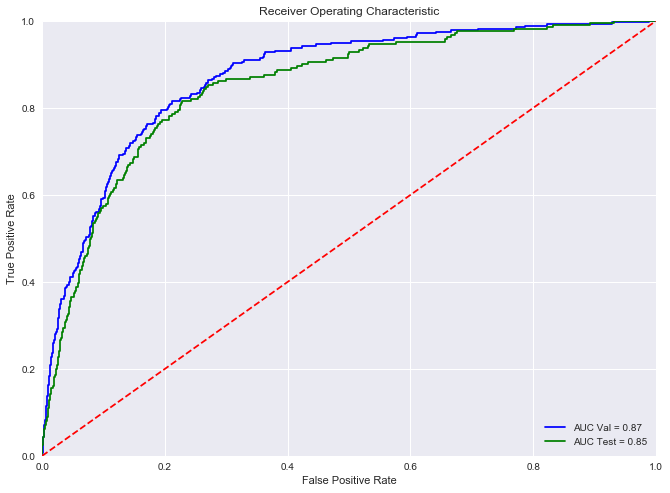

In [72]:

sgd =SGDClassifier(loss='log')

sgdmodel = sgd.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, sgdmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y,logmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, sgdmodel.predict_proba(val_X_std)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, sgdmodel.predict_proba(test_X_std)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
tuned_parameters = [{
    #'n_neighbors':[i for i in range(3,15,2)],
    'n_neighbors':[6,7,8],
    'weights' : ['distance'],
    'algorithm': ['auto']
    
}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = val_y, clf.predict_proba(val_X_std)[:,1]
    y_true2, y_pred2 = test_y, clf.predict_proba(test_X_std)[:,1]
    print('AUC Val: ' + str(roc_auc_score(y_true, y_pred)))
    print('Recall Val: ' + str(recall_score(y_true, clf.predict(val_X_std))))
    print(classification_report(y_true, clf.predict(val_X_std)))
    print()
    print('AUC Test: ' + str(roc_auc_score(y_true2, y_pred2)))
    print('Recall Test: ' + str(recall_score(y_true2, clf.predict(test_X_std))))
    print(classification_report(y_true2, clf.predict(test_X_std)))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}

Grid scores on development set:

0.984 (+/-0.001) for {'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'distance'}
0.984 (+/-0.002) for {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
0.984 (+/-0.001) for {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

AUC Val: 0.723895085489
Recall Val: 0.442446043165
             precision    recall  f1-score   support

          0       0.99      0.88      0.93     17722
          1       0.06      0.44      0.10       278

avg / total       0.98      0.88      0.92     18000


AUC Test: 0.704229866293
Recall Test: 0.473933649289
             precision    recall  f1-score   support

          0       0.99      0.87      0.93      9789
  

             precision    recall  f1-score   support

          0       0.99      0.87      0.93      9789
          1       0.07      0.47      0.13       211

avg / total       0.97      0.86      0.91     10000

Accuracy: 86.47%


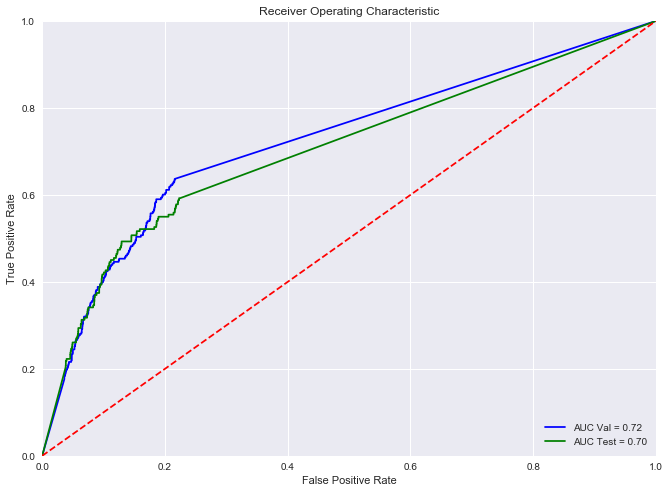

In [74]:

KNN = KNeighborsClassifier(algorithm='auto',n_jobs=-1, weights='distance',n_neighbors=7)

knnmodel = KNN.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, knnmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y, knnmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, knnmodel.predict_proba(val_X_std)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, knnmodel.predict_proba(test_X_std)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [76]:
tuned_parameters = [{
    'n_estimators':[5, 10, 15, 20, 100],
    'criterion':['gini','entropy'],    
    'max_features':['auto', None],
    'class_weight':['balanced']
}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std.values, train_y.values)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = val_y, clf.predict_proba(val_X_std)[:,1]
    y_true2, y_pred2 = test_y, clf.predict_proba(test_X_std)[:,1]
    print('AUC Val: ' + str(roc_auc_score(y_true, y_pred)))
    print('Recall Val: ' + str(recall_score(y_true, clf.predict(val_X_std))))
    print(classification_report(y_true, clf.predict(val_X_std)))
    print()
    print('AUC Test: ' + str(roc_auc_score(y_true2, y_pred2)))
    print('Recall Test: ' + str(recall_score(y_true2, clf.predict(test_X_std))))
    print(classification_report(y_true2, clf.predict(test_X_std)))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': None, 'n_estimators': 5}

Grid scores on development set:

0.040 (+/-0.039) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 5}
0.019 (+/-0.006) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
0.013 (+/-0.011) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 15}
0.013 (+/-0.006) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 20}
0.015 (+/-0.008) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}
0.036 (+/-0.017) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': None, 'n_estimators': 5}
0.022 (+/-0.016) for {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': None, 'n_esti

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      9789
          1       0.18      0.03      0.05       211

avg / total       0.96      0.98      0.97     10000

Accuracy: 97.680%


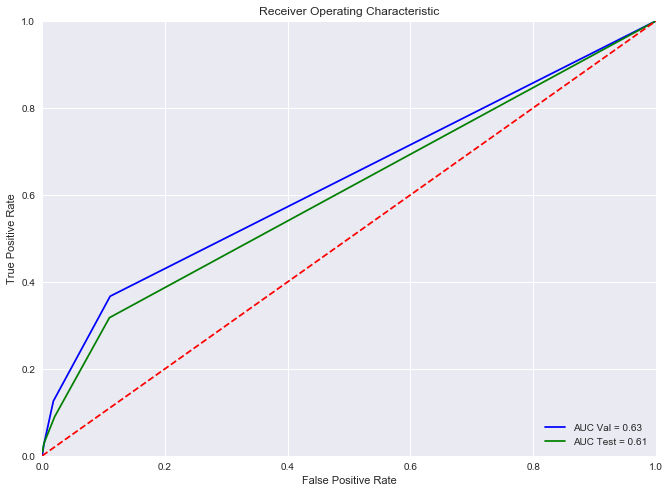

In [77]:

RF = RandomForestClassifier(class_weight='balanced',criterion='entropy', n_estimators=5)

rfmodel = RF.fit(train_X_std.values, train_y.values)

print(classification_report(test_y, rfmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y, rfmodel.predict(test_X_std.values))
print("Accuracy: %.3f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, rfmodel.predict_proba(val_X_std)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, rfmodel.predict_proba(test_X_std)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [78]:
tuned_parameters = [{
    'n_estimators':[5, 10, 15, 20,100],
    'criterion':['gini','entropy'],
    'class_weight':['balanced']
}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(ExtraTreesClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std.values, train_y.values)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = val_y, clf.predict_proba(val_X_std)[:,1]
    y_true2, y_pred2 = test_y, clf.predict_proba(test_X_std)[:,1]
    print('AUC Val: ' + str(roc_auc_score(y_true, y_pred)))
    print('Recall Val: ' + str(recall_score(y_true, clf.predict(val_X_std))))
    print(classification_report(y_true, clf.predict(val_X_std)))
    print()
    print('AUC Test: ' + str(roc_auc_score(y_true2, y_pred2)))
    print('Recall Test: ' + str(recall_score(y_true2, clf.predict(test_X_std))))
    print(classification_report(y_true2, clf.predict(test_X_std)))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 5}

Grid scores on development set:

0.050 (+/-0.022) for {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 5}
0.024 (+/-0.026) for {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 10}
0.035 (+/-0.015) for {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 15}
0.030 (+/-0.012) for {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 20}
0.028 (+/-0.019) for {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 100}
0.053 (+/-0.019) for {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 5}
0.028 (+/-0.014) for {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 10}
0.039 (+/-0.019) for {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 15}
0.026 (+/-0.019) for {'class_weight': 'balanced', 'criterion': 'entropy',

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      9789
          1       0.18      0.03      0.05       211

avg / total       0.96      0.98      0.97     10000

Accuracy: 97.53%


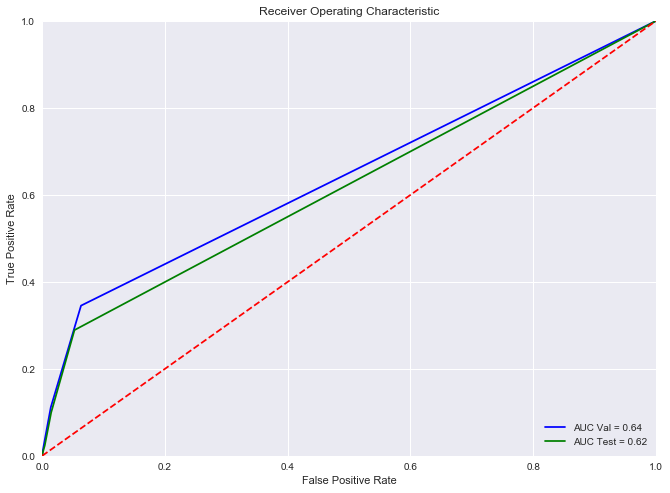

In [79]:

ET = ExtraTreesClassifier(class_weight='balanced', criterion='entropy', n_estimators=5)

etmodel = ET.fit(train_X_std.values, train_y.values)

print(classification_report(test_y, rfmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y, etmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, etmodel.predict_proba(val_X_std)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, etmodel.predict_proba(test_X_std)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
tuned_parameters = [{
    'base_estimator':[LogisticRegression()],
    'n_estimators':[10,100],
    'max_samples': [.5, .6],
    'random_state':[123],
    'n_jobs':[-1]
}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(BaggingClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(train_X_std_res, train_y_res)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = val_y, clf.predict_proba(val_X_std)[:,1]
    y_true2, y_pred2 = test_y, clf.predict_proba(test_X_std)[:,1]
    print('AUC Val: ' + str(roc_auc_score(y_true, y_pred)))
    print('Recall Val: ' + str(recall_score(y_true, clf.predict(val_X_std))))
    print(classification_report(y_true, clf.predict(val_X_std)))
    print()
    print('AUC Test: ' + str(roc_auc_score(y_true2, y_pred2)))
    print('Recall Test: ' + str(recall_score(y_true2, clf.predict(test_X_std))))
    print(classification_report(y_true2, clf.predict(test_X_std)))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'max_samples': 0.5, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 123}

Grid scores on development set:

0.835 (+/-0.002) for {'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'max_samples': 0.5, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 123}
0.835 (+/-0.002) for {'base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_sca

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      9789
          1       0.18      0.03      0.05       211

avg / total       0.96      0.98      0.97     10000

Accuracy: 76.12%


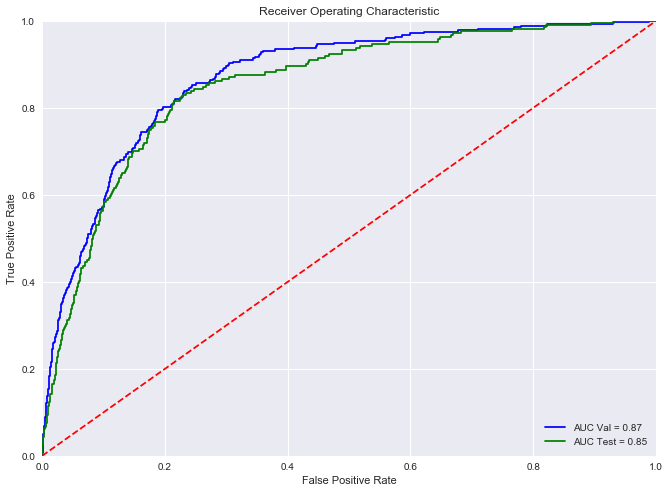

In [87]:
BG = BaggingClassifier(LogisticRegression(), max_samples=0.5, n_estimators=10, n_jobs=-1, random_state=123)

bgmodel = BG.fit(train_X_std_res, train_y_res)

print(classification_report(test_y, rfmodel.predict(test_X_std.values)))


# evaluate predictions
accuracy = accuracy_score(test_y, bgmodel.predict(test_X_std.values))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#conmat = confusion_matrix(y_test, predictions)
#print(conmat)
#plt.figure()
#helper.plot_confusion_matrix(conmat,classes = np.array(['0','1']), title='Confusion Matrix, no Normalization')

fpr, tpr, _ = roc_curve(val_y, bgmodel.predict_proba(val_X_std)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, bgmodel.predict_proba(test_X_std)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

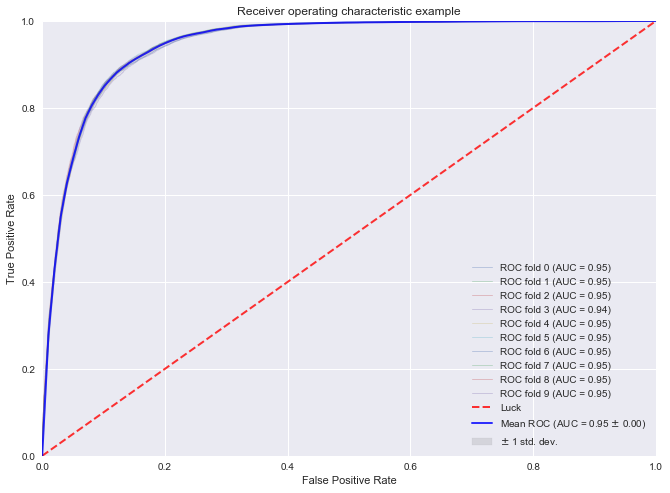

In [90]:
#ests = [('LR', logmodel),('XGB', xgbmodel), ('KNN',knnmodel), ('RF', rfmodel),('ET',etmodel)]
ests = [('LR', logmodel),('XGB', xgbmodel), ('KNN',knnmodel), ('Bagging',bgmodel)]
eclf = VotingClassifier(estimators=ests, voting='soft')


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)


#eclf.fit(train_X_std_res, train_y_res)

#for clf, label in zip([logmodel, xgbmodel, knnmodel, rfmodel, etmodel, eclf], ['LR','XGB','KNN','RF','ET','Ensemble']):
#    scores = cross_val_score(clf, test_X_std.values, test_y, cv=10, scoring='roc_auc')
#    print("AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
###########################################################################################
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

i = 0
for train, test in cv.split(train_X_std_res, train_y_res):
    probas_ = eclf.fit(train_X_std_res[train], train_y_res[train]).predict_proba(train_X_std_res[test])
    fpr, tpr, thresholds = roc_curve(train_y_res[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
####################################################################################################


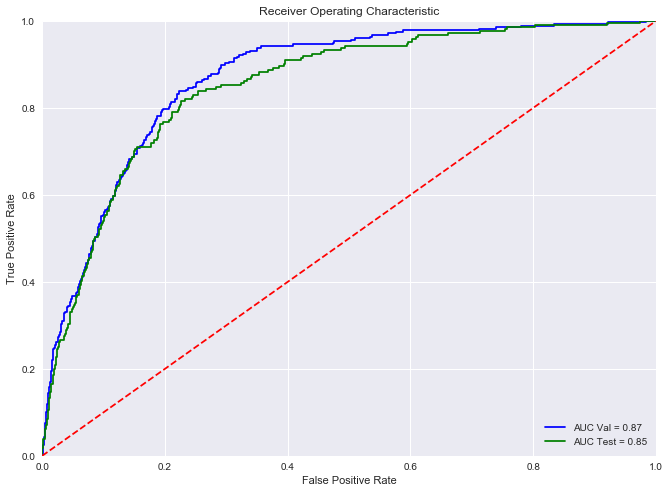

In [91]:
eclf.fit(train_X_std_res, train_y_res)

fpr, tpr, _ = roc_curve(val_y, eclf.predict_proba(val_X_std.values)[:,1])
fpr2, tpr2, _ = roc_curve(test_y, eclf.predict_proba(test_X_std.values)[:,1])
roc_auc = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Test = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


metamodel = eclf

In [151]:
tn, fp, fn, tp = confusion_matrix(test_y, eclf.predict(test_X_std.values)).ravel()
mr = (fp + fn)/(tn + fp + fn + tp)

tn, fp, fn, tp = confusion_matrix(test_y, eclf.predict(test_X_std.values)).ravel()
mr = (fp + fn)/(tn + fp + fn + tp)

print(classification_report(test_y, eclf.predict(test_X_std.values)))

print("Misclassification Rate: %.2f%%" % (mr * 100.0))
print("              Accuracy: %.2f%%" % ((1-mr) * 100.0))
print("              Recall  : " + str(recall_score(val_y, eclf.predict(val_X_std.values))))

             precision    recall  f1-score   support

          0       0.99      0.81      0.89      9789
          1       0.08      0.73      0.14       211

avg / total       0.97      0.81      0.88     10000

Misclassification Rate: 18.82%
              Accuracy: 81.18%
              Recall  : 0.758992805755


In [ ]:
# Old Model
# 1/(1+EXP(-1*(0.443634336334065 + 
#                        0.256812522789543*MAIL_SELECT.MALES_IN_HOUSEHOLD +
#                        0.105126843020721*MAIL_SELECT.FEMALES_IN_HOUSEHOLD +
#                        0.0000684374420557083*DAYS_AS_CUSTOMER +
#                        0.0372832648687244*TOTAL_TRANSACTIONS_RLT +
#                        -0.0112190400535651*MAIL_SELECT.REW_TRANSACTIONS +
#                        0.000119354146448687*MAIL_SELECT.TOTAL_PURCHASES_RLT +
#                        -0.00194951297780262*DAYS_SINCE_PURCHASE))) AS CONFIDENCE3
#

# def score(a, b, c, d, e, f):
#     proba = 1/(1+math.exp(-1*(0.443634336334065 + 
#                        0.256812522789543*a +
#                        0.105126843020721*b +
#                        0.0000684374420557083*c +
#                        0.0372832648687244*d +
#                        -0.0112190400535651*e +
#                        #0.000119354146448687*row[TOTAL_PURCHASES_RLT] +
#                        -0.00194951297780262*f)))
#     return proba
    

# base['OldScore'] = base.apply(lambda row: score(row['MALES_IN_HOUSHOLD'],
#                                                 row['FEMALES_IN_HOUSHOLD'],
#                                                 row['DAYS_AS_CUSTOMER'],
#                                                 row['TOTAL_TRANSACTIONS'],
#                                                 row['REW_TRANSACTIONS'],
#                                                 row['DAYS_SINCE_PURCHASE']), axis=1)
# base['OldPred'] = base.apply(lambda row: decide(row['OldScore']), axis=1)


In [ ]:
# tn, fp, fn, tp = confusion_matrix(base['TARGET_PURCH_NEXT15'].as_matrix(),base['OldPred'].as_matrix()).ravel()
# mr = (fp + fn)/(tn + fp + fn + tp)
# print("Misclassification Rate: %.2f%%" % (mr * 100.0))
# print("              Accuracy: %.2f%%" % ((1-mr) * 100.0))
# print("              Recall  : " + str(tp/float(tp+fn)))
# fpr, tpr, _ = roc_curve(base['TARGET_PURCH_NEXT15'].as_matrix(),base['OldScore'].as_matrix())
# roc_auc = auc(fpr, tpr)
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [168]:
#sgdpred = sgdmodel.predict(train_X_std_res)
xgbpred = xgbmodel.predict_proba(val_X_std.values)[:,1]
knn_pred = knnmodel.predict_proba(val_X_std.values)[:,1]
logpred = logmodel.predict_proba(val_X_std.values)[:,1]
etpred = etmodel.predict_proba(val_X_std.values)[:,1]
rfpred = rfmodel.predict_proba(val_X_std.values)[:,1]
bgpred = bgmodel.predict_proba(val_X_std.values)[:,1]
resarray = np.array([val_y.values, xgbpred, knn_pred, logpred, etpred, rfpred, bgpred], np.float64)

xgb_test = np.array(xgbmodel.predict_proba(test_X_std.values)[:,1])
knn_test = np.array(knnmodel.predict_proba(test_X_std.values)[:,1])
log_test = np.array(logmodel.predict_proba(test_X_std.values)[:,1])
et_test = np.array(etmodel.predict_proba(test_X_std.values)[:,1])
rf_test = np.array(rfmodel.predict_proba(test_X_std.values)[:,1])
bg_test = bgmodel.predict_proba(test_X_std.values)[:,1]
res_test = np.array([test_y.values, xgb_test, knn_test, log_test, et_test, rf_test, bg_test], np.float64)

result = pd.DataFrame(resarray.transpose(), columns = ['true_y','xgbpred', 'knnpred', 'logpred', 'etpred','rfpred', 'bgpred'])
result_test = pd.DataFrame(res_test.transpose(), columns = ['true_y','xgbpred', 'knnpred', 'logpred','etpred','rfpred', 'bgpred'])
result.describe()

,true_y,xgbpred,knnpred,logpred,etpred,rfpred,bgpred
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,0.015444,0.026117,0.124822,0.303144,0.017633,0.027600,0.304045
std,0.123316,0.032292,0.274342,0.273912,0.073109,0.083312,0.273802
min,0.000000,0.011860,0.000000,0.000016,0.000000,0.000000,0.000017
25%,0.000000,0.011860,0.000000,0.046045,0.000000,0.000000,0.046688
50%,0.000000,0.013295,0.000000,0.240687,0.000000,0.000000,0.242423
75%,0.000000,0.022879,0.000000,0.501843,0.000000,0.000000,0.503464
max,1.000000,0.339456,1.000000,0.999998,0.800000,0.800000,0.999992


In [169]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

formula = 'true_y ~ xgbpred + logpred + rfpred + bgpred'
model = smf.glm(formula=formula, data=result, family=sm.families.Binomial())
fittedmod = model.fit()

fittedmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 true_y   No. Observations:                18000
Model:                            GLM   Df Residuals:                    17995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1125.1
Date:                Thu, 12 Oct 2017   Deviance:                       2250.2
Time:                        14:50:40   Pearson chi2:                 1.65e+04
No. Iterations:                     9                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.8238      0.253    -27.006      0.000      -7.319      -6.329
xgbpred        5.0744      1.656      3.065      0.002       1.829       8.319
logpred       -5.8470     56.262     -0.104      0.917    -116.118     104.424
rfpred         0.3019      0.469      0.644      0.520      -0.617       1.221
bgpred        10.4868     56.363      0.186      0.852     -99.983     120.956
==============================================================================
"""

In [186]:
ensX = result[['xgbpred','rfpred','logpred','bgpred']].values
ensy = result[['true_y']].values




param_test1 = {
#     'max_delta_step': [0,1,2,3,4,5,6]
     'max_depth':list(range(3,12,2)),
     'min_child_weight':list(range(1,6,2))
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27, max_delta_step = 1),
     param_grid = param_test1, scoring='roc_auc', iid=False, cv=5)

gsearch1.fit(ensX, ensy.ravel())

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86688, std: 0.02974, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86461, std: 0.03095, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86447, std: 0.03132, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.85893, std: 0.02864, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.85606, std: 0.03125, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86179, std: 0.03069, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.85006, std: 0.02734, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.85485, std: 0.02791, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.85987, std: 0.02829, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.84407, std: 0.02486, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.85093, std: 0.02766, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.85803, std: 0.02744, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.83845, std: 0.02239, params: {

In [189]:
# max_delta_step=1

param_test2 = {
    'max_depth': [2,3,4],
    'min_child_weight':[0,1,2]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
     min_child_weight=3, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test2, scoring='roc_auc', iid=False, cv=5)

gsearch2.fit(ensX, ensy.ravel())

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86822, std: 0.02925, params: {'max_depth': 2, 'min_child_weight': 0},
  mean: 0.86788, std: 0.02993, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.86822, std: 0.02958, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.86754, std: 0.02965, params: {'max_depth': 3, 'min_child_weight': 0},
  mean: 0.86688, std: 0.02974, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86694, std: 0.02979, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.86378, std: 0.02716, params: {'max_depth': 4, 'min_child_weight': 0},
  mean: 0.86275, std: 0.02935, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.86102, std: 0.03198, params: {'max_depth': 4, 'min_child_weight': 2}],
 {'max_depth': 2, 'min_child_weight': 2},
 0.86822275048006614)

In [190]:
# max_delta_step=1
#max_depth = 2
#min_child_weight = 2

param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test3, scoring='roc_auc', iid=False, cv=5)

gsearch3.fit(ensX, ensy.ravel())

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86822, std: 0.02958, params: {'gamma': 0.0},
  mean: 0.86870, std: 0.02960, params: {'gamma': 0.1},
  mean: 0.86875, std: 0.02939, params: {'gamma': 0.2},
  mean: 0.86860, std: 0.02969, params: {'gamma': 0.3},
  mean: 0.86766, std: 0.03054, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.8687482998160323)

In [192]:
# max_delta_step=1
#max_depth = 2
#min_child_weight = 2
#gamma = 0.2

param_test4 = {
     'subsample':[i/10.0 for i in range(5,11)],
     'colsample_bytree':[i/10.0 for i in range(5,11)],
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=2, gamma=0.2, subsample=0.7, colsample_bytree=0.7,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test4, scoring='roc_auc', iid=False, cv=5)

gsearch4.fit(ensX, ensy.ravel())

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86711, std: 0.03220, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: 0.86670, std: 0.03321, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.86875, std: 0.02939, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: 0.86657, std: 0.03158, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: 0.86664, std: 0.03118, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: 0.86803, std: 0.03045, params: {'colsample_bytree': 0.5, 'subsample': 1.0},
  mean: 0.86711, std: 0.03220, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: 0.86670, std: 0.03321, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.86875, std: 0.02939, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.86657, std: 0.03158, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.86664, std: 0.03118, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.86803, std: 0.03045, params: {'colsample_bytree': 0.6, 'subsample'

In [193]:
# max_delta_step=1
#max_depth = 2
#min_child_weight = 2
#gamma = 0.2
# colsample_bytree = 0.5
# subsample = 0.7

param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=2,
     min_child_weight=2, gamma=0.2, subsample=0.7, colsample_bytree=0.5,
     objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27, max_delta_step=1),
     param_grid = param_test6, scoring='roc_auc', iid=False, cv=5)

gsearch6.fit(ensX, ensy.ravel())

gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86875, std: 0.02939, params: {'reg_alpha': 1e-05},
  mean: 0.86879, std: 0.02948, params: {'reg_alpha': 0.01},
  mean: 0.86758, std: 0.03102, params: {'reg_alpha': 0.1},
  mean: 0.86795, std: 0.03072, params: {'reg_alpha': 1},
  mean: 0.84596, std: 0.03384, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.86879219376215921)

In [197]:
# max_delta_step=1
#max_depth = 2
#min_child_weight = 2
#gamma = 0.2
# colsample_bytree = 0.5
# subsample = 0.7

int(sum(ensy)), len(ensy)

(278, 18000)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

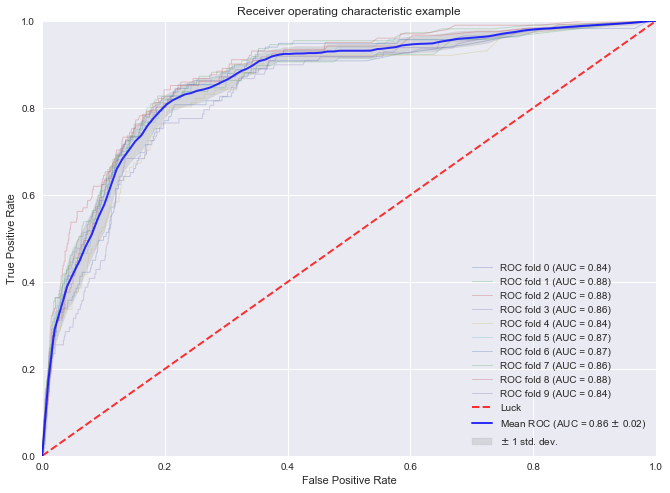

In [198]:
#ensemble = LogisticRegression(C=100, dual=False, solver='sag', max_iter=1000)
ensemble = xgb.XGBClassifier(learning_rate = 0.01,
                        n_estimators = 1000,
                        max_depth = 2,
                        min_child_weight = 2,
                        gamma = 0.2,
                        subsample = 0.7,
                        colsample_bytree = 0.5,
                        objective = 'binary:logistic',
                        scale_pos_weight = 63.75,
                        reg_alpha= 0.01,
                        max_delta_step = 1,
                        seed = 27)
#ensemble.fit(result[['xgbpred','rfpred','logpred','bgpred']].values, result[['true_y']].values)

cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=123)
ensX = result[['xgbpred','rfpred','logpred','bgpred']].values
ensy = result[['true_y']].values

#eclf.fit(train_X_std_res, train_y_res)

#for clf, label in zip([logmodel, xgbmodel, knnmodel, rfmodel, etmodel, eclf], ['LR','XGB','KNN','RF','ET','Ensemble']):
#    scores = cross_val_score(clf, test_X_std.values, test_y, cv=10, scoring='roc_auc')
#    print("AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
###########################################################################################
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

i = 0
for train, test in cv.split(ensX, ensy):
    probas_ = ensemble.fit(ensX[train], ensy[train]).predict_proba(ensX[test])
    fpr, tpr, thresholds = roc_curve(ensy[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

        0.0       1.00      0.80      0.89      9789
        1.0       0.08      0.82      0.15       211

avg / total       0.98      0.80      0.87     10000



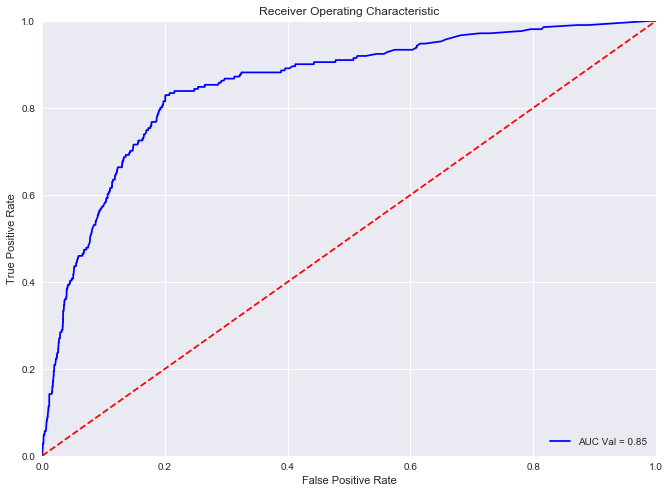

In [200]:
#ensX = result[['xgbpred','rfpred','logpred','bgpred']].values
#ensy = result[['true_y']].values


ensemble.fit(result[['xgbpred','rfpred','logpred','bgpred']].values, result[['true_y']].values)

print(classification_report(result_test[['true_y']].values, ensemble.predict(result_test[['xgbpred','rfpred','logpred','bgpred']].values)))

fpr, tpr, _ = roc_curve(result_test[['true_y']].values, ensemble.predict_proba(result_test[['xgbpred','rfpred','logpred','bgpred']].values)[:,1])

roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC Val = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




In [201]:
tn, fp, fn, tp = confusion_matrix(result_test[['true_y']].values, ensemble.predict(result_test[['xgbpred','rfpred','logpred','bgpred']].values)).ravel()
mr = (fp + fn)/(tn + fp + fn + tp)

print(classification_report(result_test[['true_y']].values, ensemble.predict(result_test[['xgbpred','rfpred','logpred','bgpred']].values)))

print("Misclassification Rate: %.2f%%" % (mr * 100.0))
print("              Accuracy: %.2f%%" % ((1-mr) * 100.0))
print("              Recall  : " + str(recall_score(result_test[['true_y']].values, ensemble.predict(result_test[['xgbpred','rfpred','logpred','bgpred']].values))))

             precision    recall  f1-score   support

        0.0       1.00      0.80      0.89      9789
        1.0       0.08      0.82      0.15       211

avg / total       0.98      0.80      0.87     10000

Misclassification Rate: 20.01%
              Accuracy: 79.99%
              Recall  : 0.824644549763


In [203]:
#[('LR', logmodel),('XGB', xgbmodel), ('KNN',knnmodel), ('RF', rfmodel),('ET',etmodel)]


joblib.dump(rfmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\pickles\tabmodelrf.pkl')
joblib.dump(xgbmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\pickles\tabmodelxgb.pkl')
joblib.dump(ensemble, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\pickles\tabmodelmeta.pkl')
joblib.dump(logmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\pickles\tabmodellog.pkl')
joblib.dump(bgmodel, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\pickles\tabmodelbg.pkl')
joblib.dump(imr, r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\Analyses\pickles\tabmodel_impute.pkl')

['C:\\users\\pairwin\\Documents\\GitHub\\IPy_Notebooks\\Analyses\\pickles\\tabmodel_impute.pkl']